In [1]:
import pandas as pd
import pickle
import re

from utilities import predictions
from utilities.info import *

In [2]:
INPUT_DIR

'C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/inputs'

## Load Venk21 and PanCan Predictions

In [3]:
venk21_pancan = pd.read_csv(f"{INPUT_DIR}/NLST_DL_vs_PanCan_Venk21.csv")
venk21_pancan.rename(columns={'Diameter [mm]': 'Diameter_mm'}, inplace=True)
venk21_pancan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [4]:
venk21_pancan['timepoint'] = venk21_pancan['StudyDate'].map(lambda d: (d - 19990102) // 10000)

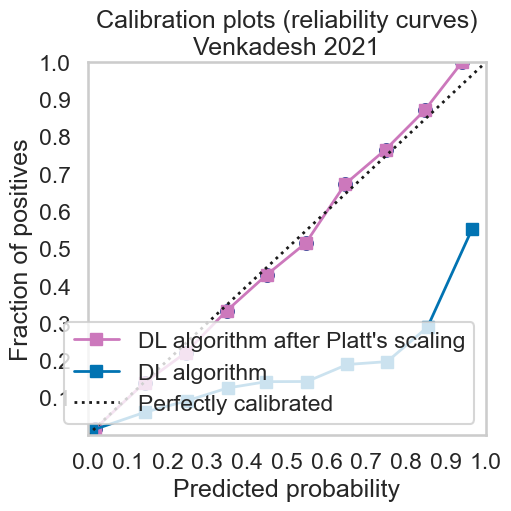

In [5]:
venk21_pancan['DL_cal'] = predictions.calibrate_preds(venk21_pancan['DL'], venk21_pancan['label'])
_= predictions.make_calibration_plots(venk21_pancan['label'], venk21_pancan['DL'], venk21_pancan['DL_cal'], title='\nVenkadesh 2021')

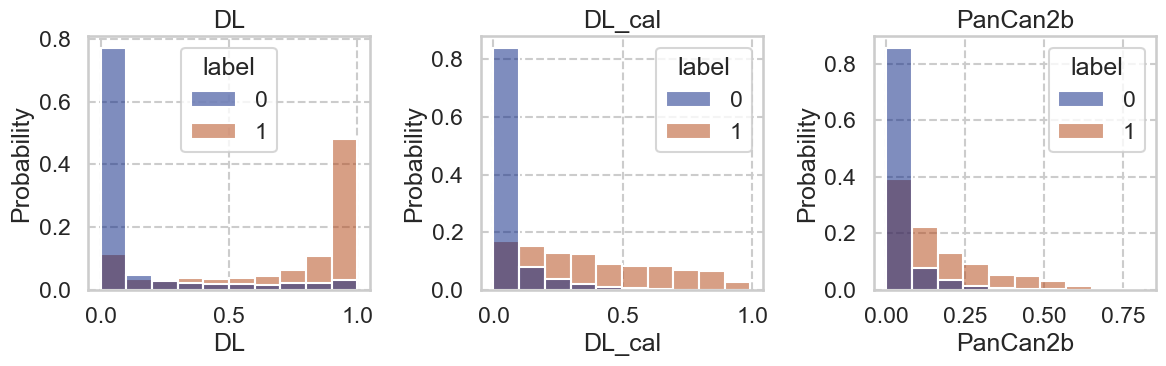

In [6]:
_ = predictions.check_scoredists(venk21_pancan, ['DL', 'DL_cal', 'PanCan2b'])

## Get Series for Sybil Predictions

This includes the ones from Venk21's cross-validation set which are NOT in Sybil's training set.

In [7]:
LOAD_SYBIL_PICKLE_FILE = True

if LOAD_SYBIL_PICKLE_FILE:
    SYBIL_SERIES_JSON_PATH = f"{INPUT_DIR}/sybil-nlst-info/sybil-nlst-pid_tp_series2split.p"
    sybil_split_dict = pickle.load(open(SYBIL_SERIES_JSON_PATH, "rb"))

    ids = list(sybil_split_dict.keys())
    splits = list(sybil_split_dict.values())
    pids = [re.split('PID-|__TimePoint-|__Series-', i)[1] for i in ids]
    timepoints = [re.split('PID-|__TimePoint-|__Series-', i)[2] for i in ids]
    siuids = [re.split('PID-|__TimePoint-|__Series-', i)[3] for i in ids]

    sybil_split_df = pd.DataFrame({'id': ids, 'split': splits, 'PatientID': pids, 'timepoint': timepoints, 'SeriesInstanceUID': siuids})

    sybil_split_df.to_csv(f"{INPUT_DIR}/sybil-nlst-info/sybil-nlst-splitinfo.csv", index=False)

else:
    sybil_split_df = pd.read_csv(f"{INPUT_DIR}/sybil-nlst-info/sybil-nlst-splitinfo.csv")

In [20]:
venk21_series_ids = set(venk21_pancan['SeriesInstanceUID'])
print("Venk21 scans (cross-validation):", len(venk21_series_ids))

sybil_train_ids = set(sybil_split_df.query('split == "train"')['SeriesInstanceUID'])
print("\nSybil train scans:", len(sybil_train_ids))
print("Venk21 - Sybil train intersection:", len(venk21_series_ids.intersection(sybil_train_ids)))

sybil_dev_ids = set(sybil_split_df.query('split == "dev"')['SeriesInstanceUID'])
print("\nSybil dev scans:", len(sybil_dev_ids))
print("Venk21 - Sybil dev intersection:", len(venk21_series_ids.intersection(sybil_dev_ids)))

sybil_test_ids = set(sybil_split_df.query('split == "test"')['SeriesInstanceUID'])
print("\nSybil test scans:", len(sybil_test_ids))
print("Venk21 - Sybil test intersection:", len(venk21_series_ids.intersection(sybil_test_ids)))

all_sybil_ids = set(sybil_split_df['SeriesInstanceUID'])
print("\nVenk21 scans not found in Sybil:", len(venk21_series_ids - all_sybil_ids))
print("Sybil scans not found in Venk21:", len(all_sybil_ids - venk21_series_ids))

unique_series_ids = venk21_series_ids - sybil_train_ids
print("\nOUR Validation set scans (not in Sybil Train):", len(unique_series_ids))

Venk21 scans (cross-validation): 10183

Sybil train scans: 28160
Venk21 - Sybil train intersection: 4271

Sybil dev scans: 6838
Venk21 - Sybil dev intersection: 947

Sybil test scans: 6282
Venk21 - Sybil test intersection: 757

Venk21 scans not found in Sybil: 4208
Sybil scans not found in Venk21: 35305

OUR Validation set scans (not in Sybil Train): 5912


In [9]:
venk21_pancan['InSybilTrain'] = venk21_pancan['SeriesInstanceUID'].isin(sybil_train_ids)
venk21_pancan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

In [10]:
sybil_infer_input = venk21_pancan.query("SeriesInstanceUID in @unique_series_ids")
sybil_infer_input.to_csv(f"{FILE_DIR}/sybil_val_infer_series.csv", index=False)
sybil_infer_input[['SeriesInstanceUID']].nunique()

SeriesInstanceUID    5912
dtype: int64

After this, convert MHA to DICOM and run Sybil's inference on `DIAGNijmegen/bodyct-sybil-lung-cancer-risk`.

## Merge Sybil Predictions

NOTE: I ran this in two jobs - one for a subset of 1172 scans, and a second for the 4739 (1 scan failed) on the rest. Ideally, you run it all at once, but I'm gonna merge them here. 

In [11]:
sybil_infer_1172 = pd.read_csv(f"{INPUT_DIR}/sybil-inference-1172.csv")
sybil_infer_4739 = pd.read_csv(f"{INPUT_DIR}/sybil-inference-4739.csv")
len(sybil_infer_1172), len(sybil_infer_4739)

(1172, 4739)

In [12]:
sybil_infer = pd.concat([sybil_infer_1172, sybil_infer_4739], axis=0, ignore_index=True).drop_duplicates(subset='SeriesInstanceUID')
sybil_infer = sybil_infer.rename(columns={f'year{n+1}': f'sybil_year{n+1}' for n in range(6)})
sybil_infer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SeriesInstanceUID  5911 non-null   object 
 1   sybil_year1        5911 non-null   float64
 2   sybil_year2        5911 non-null   float64
 3   sybil_year3        5911 non-null   float64
 4   sybil_year4        5911 non-null   float64
 5   sybil_year5        5911 non-null   float64
 6   sybil_year6        5911 non-null   float64
dtypes: float64(6), object(1)
memory usage: 323.4+ KB


In [13]:
allpreds = venk21_pancan.merge(sybil_infer, validate='m:1',
                how="left",
                on=['SeriesInstanceUID'], suffixes=(None,None))
allpreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

## Split up Nodule Type Columns

This is to make the analysis a bit easier later on.

In [14]:
allpreds['NoduleType2'] = allpreds['NoduleType']
allpreds = pd.get_dummies(allpreds, columns=['NoduleType2'], prefix='', prefix_sep='')
allpreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            16077 non-null  int64  
 1   StudyDate            16077 non-null  int64  
 2   SeriesInstanceUID    16077 non-null  object 
 3   CoordX               16077 non-null  float64
 4   CoordY               16077 non-null  float64
 5   CoordZ               16077 non-null  float64
 6   LesionID             16077 non-null  int64  
 7   NoduleType           16077 non-null  object 
 8   Spiculation          16077 non-null  bool   
 9   Diameter_mm          16077 non-null  float64
 10  Age                  16077 non-null  int64  
 11  Gender               16077 non-null  int64  
 12  FamilyHistoryLungCa  16077 non-null  bool   
 13  Emphysema            16077 non-null  bool   
 14  NoduleInUpperLung    16077 non-null  bool   
 15  NoduleCounts         16077 non-null 

## Save Everything

In [15]:
allpreds.to_csv(f"{FILE_DIR}/nlst_allmodels.csv", index=False)